<a href="https://colab.research.google.com/github/baricio00/Health-Informatics-2025-26/blob/main/log1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/'
df = pd.read_csv(PATH + 'rotterdam.csv')

num_vars = ["year", "age", "nodes", "pgr", "er", "rtime", "dtime"]
cat_vars = ["hospital_id", "meno", "size", "grade", "hormon", "chemo", "recur", "death"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
selected_features = ['age','year','nodes','er','pgr', 'size', 'grade', 'meno', 'hormon', 'chemo', 'recur', 'death'];
df1 = df[selected_features];
cat_var_df1=['meno','hormon','chemo','recur','size','grade', 'death'];
num_var_df1=['age','year','nodes','er','pgr'];

In [39]:
df1

,age,year,nodes,er,pgr,size,grade,meno,hormon,chemo,recur,death
0,74,1992,0,291,35,<=20,3,1,0,0,0,0
1,79,1984,0,611,36,20-50,3,1,0,0,0,0
2,44,1983,0,0,138,<=20,2,0,0,0,1,0
3,70,1985,0,12,0,20-50,3,1,0,0,0,0
4,75,1983,0,409,260,<=20,3,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2977,73,1990,1,142,167,20-50,3,1,0,0,1,1
2978,75,1987,11,20,5,>50,3,1,1,0,1,1
2979,79,1985,6,21,189,20-50,3,1,0,0,0,1
2980,71,1983,0,55,0,<=20,3,1,0,0,0,1


In [49]:
X=df1.drop('recur',axis=1)
y=df1['recur']

X=sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234)
train_index = X_train.index
test_index = X_test.index


X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)



In [50]:
import time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import ExhaustiveFeatureSelector

numeric_vars = num_var_df1.copy()
categorical_vars = cat_var_df1.copy()
categorical_vars.remove('recur')

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()
n = len(y_test)

In [52]:
X_train_processed = pd.DataFrame(X_train_proc, columns=feature_names, index=X_train.index)
X_train_processed = sm.add_constant(X_train_processed, prepend=True) # Add constant as the first column

logit_model = sm.Logit(y_train, X_train_processed).fit()

print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.611308
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  recur   No. Observations:                 2385
Model:                          Logit   Df Residuals:                     2372
Method:                           MLE   Df Model:                           12
Date:                Tue, 16 Dec 2025   Pseudo R-squ.:                  0.1179
Time:                        15:55:25   Log-Likelihood:                -1458.0
converged:                       True   LL-Null:                       -1652.8
Covariance Type:            nonrobust   LLR p-value:                 5.630e-76
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0818      0.144     -0.567      0.570      -0.365       0.201
num__age         

Odds ratio:

In [53]:
coef = logit_model.params
odds_ratios = np.exp(coef) # e^coef

conf = logit_model.conf_int()
conf.columns = ['2.5%', '97.5%']
conf = np.exp(conf)  # Exponentiate the betas' CIs to get ORs' CIs

or_summary = pd.DataFrame({
    "Coefficient": coef,
    "Odds Ratio": odds_ratios,
    "2.5% CI OR": conf['2.5%'],
    "97.5% CI OR": conf['97.5%']
})

print(or_summary)

                Coefficient  Odds Ratio  2.5% CI OR  97.5% CI OR
const             -0.081846    0.921414    0.694511     1.222449
num__age          -0.310017    0.733435    0.630149     0.853649
num__year         -0.035170    0.965441    0.879370     1.059937
num__nodes         0.883670    2.419764    2.086268     2.806571
num__er            0.006118    1.006137    0.912724     1.109109
num__pgr          -0.044684    0.956299    0.869713     1.051506
cat__meno_1        0.072939    1.075665    0.795409     1.454668
cat__hormon_1     -0.515296    0.597324    0.432788     0.824413
cat__chemo_1      -0.283710    0.752985    0.585301     0.968708
cat__size_<=20    -0.510335    0.600294    0.497246     0.724698
cat__size_>50      0.045508    1.046559    0.748386     1.463531
cat__grade_3       0.633829    1.884814    1.535161     2.314106
cat__death_1      -0.108367    0.897298    0.736940     1.092549


Odds ratio plot:

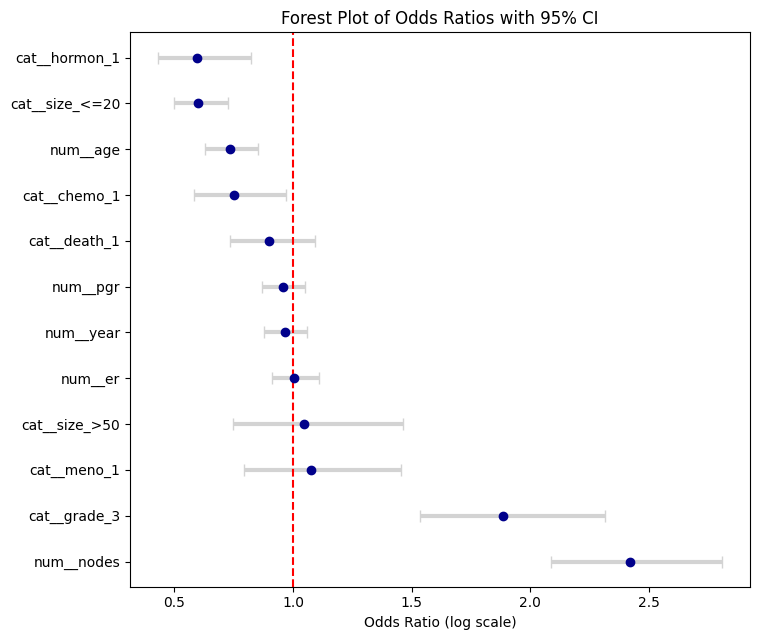

In [54]:
# Sort by odds ratio for better visualization
or_summary = or_summary.sort_values(by="Odds Ratio", ascending=False)

or_summary = or_summary.drop('const')

fig, ax = plt.subplots(figsize=(8, len(or_summary) * 0.6))

# Plot the OR as points with confidence intervals
ax.errorbar(or_summary['Odds Ratio'], or_summary.index,
            xerr=[or_summary['Odds Ratio'] - or_summary['2.5% CI OR'], or_summary['97.5% CI OR'] - or_summary['Odds Ratio']],
            fmt='o', color='darkblue', ecolor='lightgray', elinewidth=3, capsize=4)

# Add a vertical line at OR = 1 (meaning no effect)
ax.axvline(1, color='red', linestyle='--')

ax.set_xlabel("Odds Ratio (log scale)")
ax.set_title("Forest Plot of Odds Ratios with 95% CI")
#ax.set_xscale("log")  # Log scale is sometimes useful for better visualization

plt.show()